# Analyse der Webanwendung  "PetClinic"  
   
   

## _Priorisierung von Umbauarbeiten nach Nutzungsgrad_


## Einlesen der Nutzungsstatistiken

In [1]:
import pandas as pd

coverage = pd.read_csv("../dataset/jacoco.csv")
coverage = coverage[
                ['PACKAGE',
                 'CLASS',
                 'LINE_COVERED',
                 'LINE_MISSED']]
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1
2,org.springframework.samples.petclinic.model,Specialty,1,0
3,org.springframework.samples.petclinic.model,PetType,1,0
4,org.springframework.samples.petclinic.model,Vets,0,4


### Berechnung zusätzlicher Messwerte und Schlüssel

In [2]:
coverage['lines'] = coverage.LINE_COVERED + coverage.LINE_MISSED
coverage['ratio'] = coverage.LINE_COVERED / coverage.lines
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage[['fqn', 'ratio']].head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


### Laden der Daten in die Graphdatenbank

In [3]:
import py2neo
graph = py2neo.Graph()

query="""
    UNWIND {coverage_data} as coverage
    MATCH (t:Type {fqn : coverage.fqn})
    MERGE (t)-[:HAS_MEASURE]->(m)
    SET 
        m:Measure:Coverage, 
        m.ratio = coverage.ratio
    RETURN t.fqn as fqn, m.ratio as ratio
"""
coverage_dict = coverage.to_dict(orient='records')
result = graph.run(query, coverage_data=coverage_dict).data()
pd.DataFrame(result).head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


## Aggregation der Messwerte nach Subdomänen

In [4]:
query = """
MATCH 
  (t:Type)-[:BELONGS_TO]->(s:Subdomain),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)
RETURN 
  s.name as ASubdomain,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Changes,
  AVG(co.ratio) as Coverage,
  COUNT(DISTINCT b) as Bugs,
  SUM(DISTINCT t.lastMethodLineNumber) as Lines
ORDER BY Coverage ASC, Bugs DESC
"""

### Ergebnisse nach Subdomänen

In [5]:
result = pd.DataFrame(graph.data(query))
result

,ASubdomain,Bugs,Changes,Coverage,Lines,Types
0,Vet,0,75,0.170000,313,5
1,Visit,0,90,0.368056,472,6
2,Pet,1,167,0.490069,746,11
3,Owner,3,94,0.506932,531,4
4,crossfunctional,2,53,0.589231,268,5
5,Clinic,0,26,0.888889,110,1
6,Person,0,5,1.000000,53,1
7,Specialty,0,4,1.000000,28,1


### Umbenennung nach geläufigen Begriffen

In [6]:
plot_data = result.copy()
plot_data = plot_data.rename(
    columns= {
        "Changes" : "Investment",
        "Coverage" : "Utilization",
        "Lines" : "Size"})
plot_data

,ASubdomain,Bugs,Investment,Utilization,Size,Types
0,Vet,0,75,0.170000,313,5
1,Visit,0,90,0.368056,472,6
2,Pet,1,167,0.490069,746,11
3,Owner,3,94,0.506932,531,4
4,crossfunctional,2,53,0.589231,268,5
5,Clinic,0,26,0.888889,110,1
6,Person,0,5,1.000000,53,1
7,Specialty,0,4,1.000000,28,1


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# haesslich zusammengehackte Plot-Funktion
def plot_portfolio_diagramm(plot_data, name):
    x = "Investment"
    y = "Utilization"
    
    ax = plot_data.plot.scatter(
        x,
        y,
        s=plot_data.Size * 10,
        alpha=0.7,
        title="Return on Investment ({})".format(name),
        figsize=[10,7],
        fontsize=14
    )

    ax.title.set_size(24)
    ax.title
    plt.xlabel(x, fontsize=18)
    plt.ylabel(y, fontsize=18)
    
    ax.plot(
        [plot_data[x].max()/2, plot_data[x].max()/2],
        [0, plot_data[y].max()], color='k', linestyle='--', linewidth=0.6)
    ax.plot(
        [0, plot_data[x].max()],
        [plot_data[y].max()/2,plot_data[y].max()/2], color='k', linestyle='--', linewidth=0.6)
    ax.text(plot_data[x].max()*1/4, plot_data[y].max()*3/4, "Success", ha="center", fontsize=24)
    ax.text(plot_data[x].max()*3/4, plot_data[y].max()*3/4, "Beware", ha="center", fontsize=24)
    ax.text(plot_data[x].max()*1/4, plot_data[y].max()*1/4, "Watch", ha="center", fontsize=24)
    ax.text(plot_data[x].max()*3/4, plot_data[y].max()*1/4, "Failure", ha="center", fontsize=24)

### Vier-Felder-Matrix zur Priorisierung nach Subdomänen

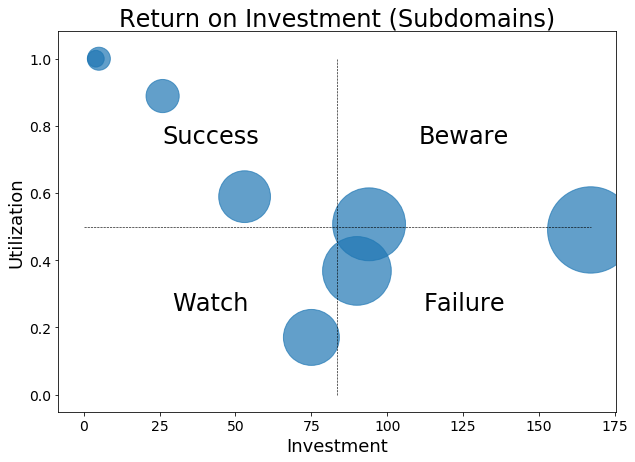

In [8]:
plot_portfolio_diagramm(plot_data, "Subdomains")

## Aggregation der Messwerte nach technischen Aspekten

In [9]:
query = """
MATCH 
  (t:Type)-[:IS_A]->(ta:TechnicalAspect),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)   
RETURN 
  ta.name as ATechnicalAspect,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Investment,
  AVG(co.ratio) as Utilization,
  COUNT(DISTINCT b) as Bugs,
  SUM(DISTINCT t.lastMethodLineNumber) as Size
ORDER BY Utilization ASC, Bugs DESC
"""

### Ergebnisse nach technischen Aspekten

In [10]:
result = pd.DataFrame(graph.data(query))
result

,ATechnicalAspect,Bugs,Investment,Size,Types,Utilization
0,jdbc,1,152,644,8,0.000000
1,util,2,23,144,2,0.371429
2,web,2,156,576,7,0.618619
3,jpa,0,54,188,4,0.702501
4,model,1,91,696,10,0.731240
5,service,0,26,110,1,0.888889
6,petclinic,0,5,110,1,1.000000


### Vier-Felder-Matrix zur Priorisierung nach technischen Aspekten

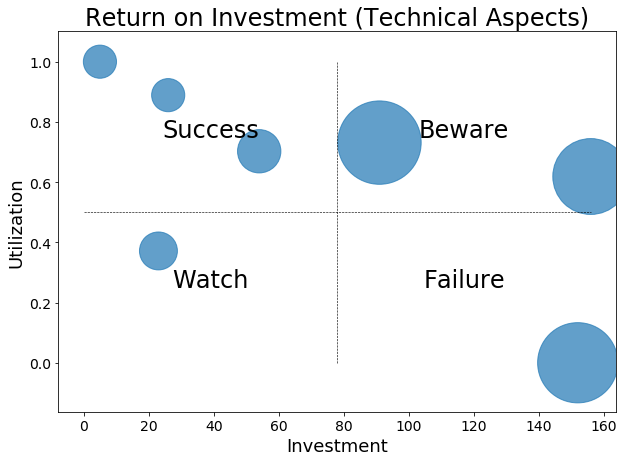

In [11]:
plot_portfolio_diagramm(result, "Technical Aspects")

## Ende Demo